I will perform in this notebook the feature selection techniques /if any/, as well as the modelling part. 
To choose the right model and parameters, I will split additionally the Test set into Test and Validation set. At this point, I will do it just before the modelling. 

In [24]:
import pandas as pd
import numpy as np
import math

from math import sqrt
import regex as re
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
from cycler import cycler

import seaborn as sns
sns.set()

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textacy import preprocessing
import textacy
from nltk.corpus import stopwords
from nltk.stem import *

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.model_selection import train_test_split
from sklearn import metrics
# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

# for the Q-Q plots
import scipy.stats as stats


# for one hot encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier

# to determine the p-values with anova
from sklearn.feature_selection import f_classif, f_regression

# to select features
from sklearn.feature_selection import SelectKBest, SelectPercentile

from sklearn.metrics import roc_auc_score, r2_score, mean_squared_error
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [25]:
X_train = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_train.pkl')
y_train = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_train.pkl')
X_test = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/X_test.pkl')
y_test = pd.read_pickle('/Users/asyagadzhalova/Documents/GitHub/Boston-Airbnb-data/src/data/processed/y_test.pkl')

In [26]:
X_train.shape

(2475, 137)

In [27]:
X_test.shape

(1076, 137)

# Filter methods

## Constant features removal

In [5]:
sel = VarianceThreshold(threshold=0)

sel.fit(X_train)  # fit finds the features with zero variance

VarianceThreshold(threshold=0)

In [6]:
#Number of features with 0 variance -> those are constant and should be removed
sum(~sel.get_support())

0

## Quasi-constant features

In [7]:
sel = VarianceThreshold(threshold=0.01)  
sel.fit(X_train)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [8]:
#Number of features with 0 variance -> those are constant and should be removed
quasi_constant = X_train.columns[~sel.get_support()]

len(quasi_constant)

20

There are 20 variables with 1% variance. 

In [99]:
quasi_constant

Index(['latitude', 'longitude', 'free parking street', 'other pet(s)',
       'paid parking premises', 'neighbourhood_cleansed_Hyde Park',
       'neighbourhood_cleansed_Longwood Medical Area',
       'neighbourhood_cleansed_Bay Village', 'neighbourhood_cleansed_Mattapan',
       'neighbourhood_cleansed_Leather District', 'property_type_Other',
       'property_type_Boat', 'property_type_Villa',
       'property_type_Entire Floor', 'bed_type_Pull-out Sofa',
       'bed_type_Couch', 'response_rate_buckets_(40.0, 50.0]',
       'response_rate_buckets_(0.0, 20.0]',
       'response_rate_buckets_(20.0, 40.0]',
       'accept_rate_buckets_(0.0, 20.0]'],
      dtype='object')

In [75]:
# capture feature names

#feat_names = X_train.columns[sel.get_support()]

In [100]:
#remove the quasi-constant features

#X_train = sel.transform(X_train)
#X_test = sel.transform(X_test)

#X_train.shape, X_test.shape

In [101]:
# trasnform the array into a dataframe

#X_train = pd.DataFrame(X_train, columns=feat_names)
#X_test = pd.DataFrame(X_test, columns=feat_names)

#X_test.head()

## Univariate feature selection
based on ANOVA tests

<AxesSubplot:>

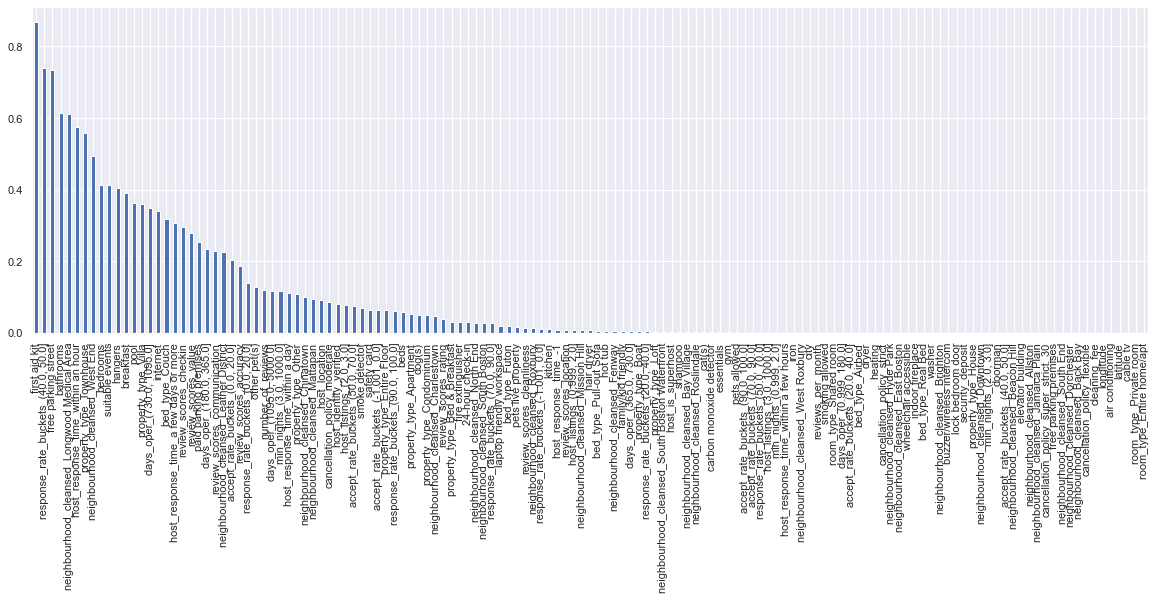

In [9]:
# univariate anova
univariate = f_regression(X_train, y_train)

# plot values
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False).plot.bar(figsize=(20,6))

In [109]:
col_sel = list(univariate[univariate<0.05].index)

In [117]:
X_train_tr = X_train[col_sel].copy()
X_test_tr = X_test[col_sel].copy()

In [111]:
X_train_tr.shape

(2475, 86)

In [132]:
X_train.shape

(2475, 129)

In [133]:
y_train.shape

(2475,)

In [134]:
from sklearn.feature_selection import SelectFromModel
sel_ = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=10))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=10))

In [135]:
# let's make a list and count the selected features
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

20

In [136]:
print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 129
selected features: 20
features with coefficients greater than the mean coefficient: 20


In [137]:
# select features in the dataframes

X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

X_train.shape, X_test.shape

((2475, 20), (1076, 20))

In [34]:
X_train.shape

(2475, 137)

In [35]:
y_train.shape

(2475,)

In [36]:
X_test.shape

(538, 137)

## Train-validation-test sets

In [32]:
#X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [42]:
from sklearn.model_selection import GridSearchCV

In [46]:
# Create a based model
rf = RandomForestRegressor()

In [59]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [40, 60, 80, 90, 100, 110],
    'max_features': ["sqrt","log2","auto"],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 400]
}

In [60]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [61]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [40, 60, 80, 90, 100, 110],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 400]},
             verbose=2)

In [62]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [63]:
y_pred = grid_search.predict(X_test)

In [64]:
r2_score(y_test,y_pred)

0.3336448262756925

In [65]:
x_pred = grid_search.predict(X_train)

In [68]:
r2_score(y_train,x_pred)

0.8112433105947146

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_f

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_f

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=   1.8s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_fe

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   1.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_fea

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   1.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_f

[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=40, max_f

## Models

In [10]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [11]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

In [12]:
#R 2 based on training set
r2_score(y_train,train_pred)

0.9151345935578648

In [13]:
#R 2 based on training set
r2_score(y_test,test_pred)

0.3602731914177024

In [21]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
pd.DataFrame(rf.feature_importances_, index = X_train.columns)

,0
host_location,0.005472
host_is_superhost,0.004480
host_identity_verified,0.005610
city,0.001898
latitude,0.151703
longitude,0.122175
bathrooms,0.011234
bedrooms,0.008497
beds,0.015427
security_deposit,0.026179


In [16]:
rf1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf1.fit(X_test, y_test)

RandomForestRegressor(random_state=42)

In [17]:
train_pred1 = rf1.predict(X_test)
test_pred1 = rf1.predict(X_train)

In [18]:
r2_score(y_test,train_pred1)

0.9031548725830023

In [19]:
r2_score(y_train,test_pred1)

0.31759201023072126

In [20]:
pd.DataFrame(rf1.feature_importances_, index = X_test.columns)

,0
host_location,0.007214
host_is_superhost,0.002968
host_identity_verified,0.008449
city,0.003381
latitude,0.144162
longitude,0.135125
bathrooms,0.024389
bedrooms,0.006521
beds,0.011210
security_deposit,0.030817


In [169]:
X_test['host_total_listings_count'].value_counts().sort_values(ascending=False)

1      489
2      160
3       60
4       46
749     41
7       29
558     26
5       23
6       23
313     19
363     17
24      16
52      15
11      13
22      13
8       12
18      10
13       9
30       6
12       6
14       5
16       5
21       5
122      5
15       4
20       3
9        3
307      3
37       3
28       2
10       2
0        1
71       1
17       1
Name: host_total_listings_count, dtype: int64

In [168]:
X_train['host_total_listings_count'].value_counts().sort_values(ascending=False)

1      1105
2       334
3       156
4       111
749      95
5        60
7        54
558      53
6        44
313      42
11       41
363      41
52       35
22       32
24       32
18       23
307      22
15       21
30       18
12       17
37       17
16       16
8        16
13       13
10       12
21       12
20       11
17       10
14       10
122       8
28        6
9         6
0         1
45        1
Name: host_total_listings_count, dtype: int64

In [127]:
lr.fit(X_train_tr,y_train)

LinearRegression()

In [128]:
train_pred_lr = lr.predict(X_train_tr)
test_pred_lr = lr.predict(X_test_tr)

In [129]:
#R 2 based on training set
r2_score(y_train,train_pred_lr)

0.3405098332965871

In [130]:
r2_score(y_test,test_pred_lr)

0.24657293858459162